# Homework 5: Clustering

1. PCA

2. [t-SNE](#tsne)

3. [K-means](#kmean)

4. [Hierarchial clustering](#hc)

## PCA

1. [How many components did you use? Why?](#PCA_1)
    
    154 See explanation

2. [Plot the first two components. Do you notice any trends? What is this plot showing us?](#PCA_1)

    It kinda looks like an icecream cone. See explanation

3. [Why would you use PCA? What is it doing? And what are the drawbacks?](#PCA_3)
    
    To reduce dimensions. See explanation

4. [Plot some of the images, the compress them using PCA and plot again. How does it look?](#PCA_4)

    Not too shabby. See explanation

Please click the links to see the answer

In [40]:
from sklearn.datasets import fetch_mldata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
warnings.filterwarnings("ignore",category=DeprecationWarning) # get rid of depreciation warnings

In [2]:
mnist = fetch_mldata('MNIST original')
X = mnist.data/255.0
y = mnist.target

train_df = pd.read_csv("/Users/jacobbills/Desktop/python/Clustering/train.csv") # import the data set from kaggle
# because the fetch_mldata wasn't working
test_df = pd.read_csv("/Users/jacobbills/Desktop/python/Clustering/test.csv") # import the test set

In [3]:
train_df.drop("label", axis=1, inplace=True) # drop the label column because we're doing clustering

In [4]:
frame = [train_df, test_df]
all_df = pd.concat(frame)

In [5]:
all_df.head() #yes they combined correctly

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
all_scale = all_df/255

In [25]:
pca = PCA(n_components=2)
X_2dim = pca.fit_transform(all_scale)

In [8]:
X_2dim.shape # checking to see if it put everything in

(70000, 2)

In [20]:
pca.explained_variance_ratio_ # how much of the variance is explained by the first two principal components

array([0.09746116, 0.07155445])

<a id='PCA_1'></a>
So using the first two components, about 9.7%+7.2% = 16.9% of the variance in the data is explained. I will plot these first two components and then use a cumulative graph to see how many componenets I should use by the end. As can be seen from the graph below, it definitely is wider along the X-axis than the y-axis. Also, it is a lot less variance on the Y axis as the X-axis increaes, kind of giving it an ice-cream cone sort of shape. Graphing with only the first 1000 points confirms this shape. From the cumaltive graph, there's a clear elbow a little before 30 components, as can be seen where I drew the line. These seem to explain about 75% of the variation in the sample. However, I might as well try to explain 95% of the variance and see where that takes me. I'll do this by including it in the code with the plot. From here, it seems I will need to use 154 variables. I will confirm this using SciKit Learn's smart pca.

In [23]:
def two_comp_plot(num, df): # turning Tyler's code into a more customizable function
    plt.scatter(df[:num,0], df[:num,1], alpha=.1) # big scatter plot using first 2 PC
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Graph of Two Principal Components with " + str(num) + " observations")

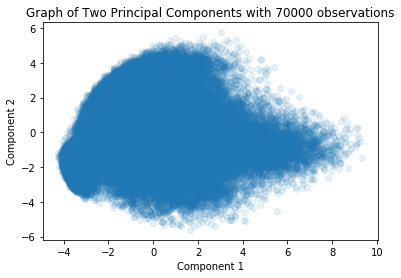

In [26]:
two_comp_plot(70000, X_2dim)

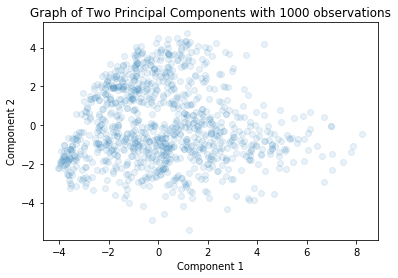

In [27]:
two_comp_plot(1000, X_2dim)

In [56]:
def pca_plot_cum_ratio(df, num, elbow, target): # turning Tyler's code into something more customizable
    pca = PCA(n_components=num)
    X_pca = pca.fit_transform(df)
    cum_ratio = np.cumsum(pca.explained_variance_ratio_)
    index = np.argmax(cum_ratio >= target)
    print(str(index+1) + " components are needed to explain")
    print(str(cum_ratio[index]*100) + " percent of the variance")
    plt.plot(range(len(cum_ratio)), cum_ratio)
    plt.vlines(ymin=0,ymax=cum_ratio[elbow], x=elbow)
    plt.vlines(ymin=0,ymax=cum_ratio[index], x=index)
    plt.xlabel("Number of Components")
    plt.ylabel("Percentage of Variance explained")
    plt.title("Cumulative Variance explained")

154 components are needed to explain
95.0231494453723 percent of the variance


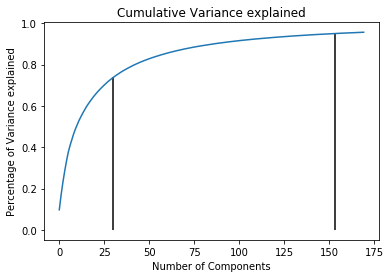

In [57]:
pca_plot_cum_ratio(all_scale, 170, 30, .95)

In [55]:
pca = PCA(n_components=0.95) #smart PCA
X_pca = pca.fit_transform(all_scale)
print(X_pca.shape)

(70000, 154)


<a id='PCA_3'></a>

So why would I use PCA? Well, in theory, it is to reduce the dimensions of the data without losing too much data. That way, processes that rely on the number of dimensions like K-nearest neighbors will not overfit nearly as much and will hopefully be more accurate. I have also used PCA when analyzing surveys. In that case, I was trying to see if the different survey questions were measuring the same underlying factor (in this case, acceptance of corruption). As for what PCA is doing, it is projecting the data on the various axes that maximize the variance in the data (using Single Vector Decompoistion). That way, the least amount of variance is lost with each one. The first component has the highest variance and then it keeps decreasing with each one. The drawback of course is that you are losing some of the variance and therefore some of the story that the data is telling. It can also be very difficult to interpret what each component means. In the case of my survey, I had a good idea because I wrote the survey questions and could look at how each one performed relative to each component. That is not ordinarly the case and does not scale well. 

### Image Compression using PCA
I will now try to compress some images using PCA and see how well it works for that. I will write a function that will plot the original number, then compressed using the 95% number and then using the elbow number (well, I was lazy so it just plots it 3 times, once originally, and then with two custom compressions). I found the code for visualizing the numbers [here](https://stackoverflow.com/questions/37228371/visualize-mnist-dataset-using-opencv-or-matplotlib-pyplot) because honestly I did not care enough to figure out how to do it myself. I also used [this](https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Image_Reconstruction_and_such.ipynb) for help in plotting the compressed versions. As can be seen, the 95% compression works pretty well while the elbow compression basically can give you a vague idea of what number it is but not much more

In [117]:
def array_reshaper(df, position): # since the original df is not in an array that the plotting function likes 
    number = df.loc[position]
    array = np.array(number, dtype='uint8')
    return array

def plot_number(array, title): # plots an array into a 28x28 grayscale function (as is tradition for these numbers)
    array = array.reshape((28,28))
    plt.imshow(array, cmap='gray')
    plt.title(title)

In [118]:
def compression_example(df, position, com_1, com_2): #Takes an image and then compresses it twice for comparison
    plt.figure(figsize=(12,4));
    plt.subplot(1, 3, 1);
    title = "Original Number"
    array = array_reshaper(df, position)
    plot_number(array, title)
    ### now with the 95% level of compression
    pca = PCA(n_components=com_1)
    _95 = pca.fit_transform(df)
    apprx = pca.inverse_transform(_95)
    plt.subplot(1,3,2);
    title = '95% Compression'
    plot_number(apprx[position], title)
    ### now with wherever I put the elbow
    pca = PCA(n_components=com_2)
    elbow = pca.fit_transform(df)
    apprx = pca.inverse_transform(elbow)
    plt.subplot(1,3,3);
    title = 'Compression with ' + str(com_2) + " Components"
    plot_number(apprx[position], title) 

<a id='PCA_4'></a>

Position 2342
Position 9
Position 7628
Position 15892
Position 42


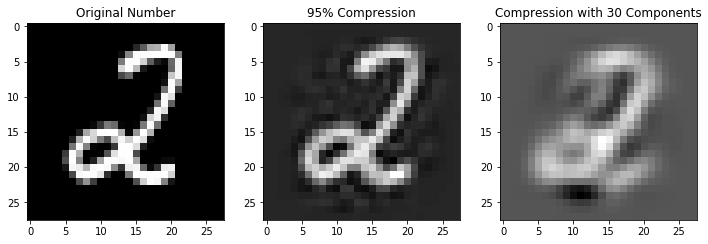

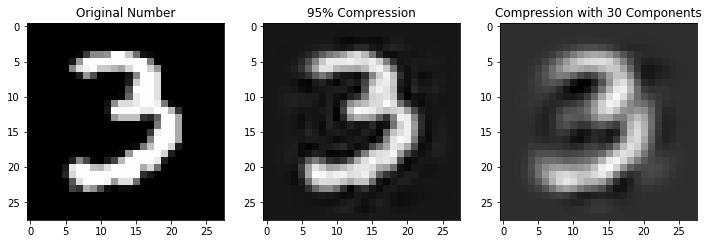

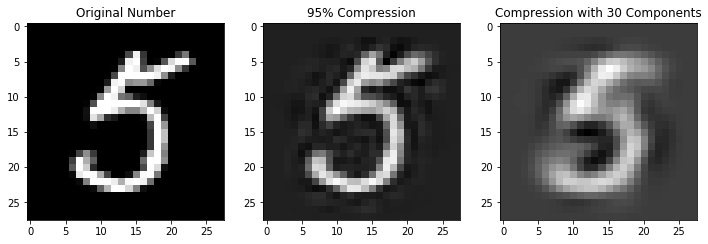

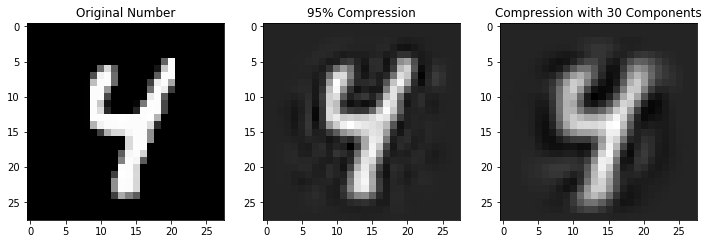

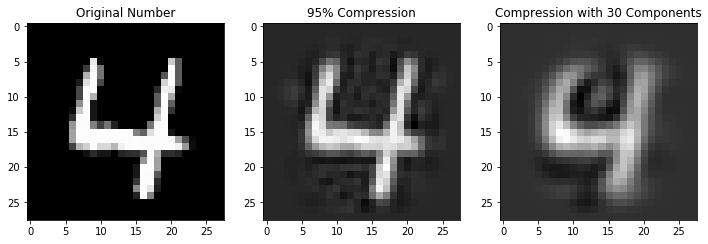

In [116]:
random_positions = [2342, 9, 7628, 15892, 42] 
for x in random_positions:
    print("Position "+ str(x))
    compression_example(train_df, x, 154, 30)

<a id='tsne'></a>
## t-SNE

first two components: 10,0000 random sample

1. How does this plot differ from your PCA plot

    It actually lumps clusters together

2. [How robust is it to changes in perplexity?](#tsne2)

    Quite

3. [How robust is it to different learning rates and number of iterations?](#tsne_3)

    Quite

Beyond these questions, the good news is that the mnist data is working again, so I can use that and have labels for everything. 

I chose to use a PCA of 77 since that's half of my 95% but still a lot more than the elbow, which was already covering some 75% of the variance. This should hopefully reduce time by enough and still be reasonable. I'll first try with a perplexity of 50 and then compare that the the PCA plot. I took the formula that Tyler had in his notebook and turned into a single function so that I can iterate over many things later on easily. Whenever I tried graphing colors on the PCA graph it turned very messy and unreadable, but the general trend is that it displays no clear patter while the t-SNE does have fairly distinct clusters. This makes sense since there is a lot more information packed into the t-SNE graph than in the two-component PCA graph.

In [6]:
def tsne_easy(n_comp, df, target, perplex, itern, learning):
    pca = PCA(n_components=n_comp) 
    X_pca = pca.fit_transform(df)

    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000

    tsne = TSNE(n_components=2, verbose=1, perplexity=perplex, n_iter=itern, learning_rate=learning)
    tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
    
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = target[rows[:n_select]]
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
    plt.title("t-SNE with perplexity " + str(perplex) + ", " + str(itern) + " iterations and a learning rate of " +str(learning))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.038s...
[t-SNE] Computed neighbors for 10000 samples in 38.359s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.048878
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.963402
[t-SNE] KL divergence after 1000 iterations: 1.702732


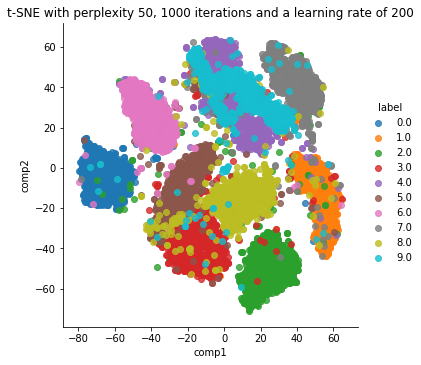

In [191]:
tsne_easy(77,X,y,50,1000,200)

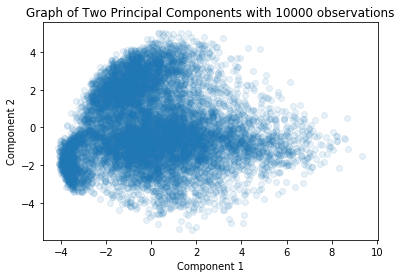

In [30]:
two_comp_plot(10000, X_2dim)

<a id='tsne2'></a>
Now I will check robustness. I will do this by creating a simple tSNE graphing function and then running it over a couple of different perplexities to see how it does. I decided that 30 is probably the best perplexity for looking good vs time taken. This is quite robust to changes in perplexity though, so I'm not too worried.

perplexity: 5
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.039s...
[t-SNE] Computed neighbors for 10000 samples in 22.222s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.191804
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.943382
[t-SNE] KL divergence after 1000 iterations: 1.948470
perplexity

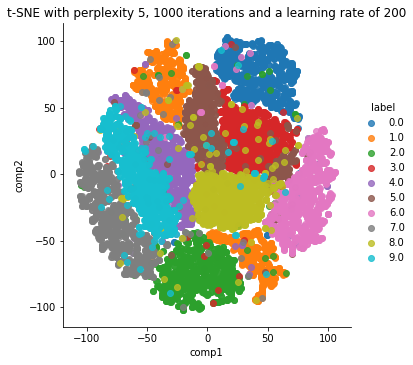

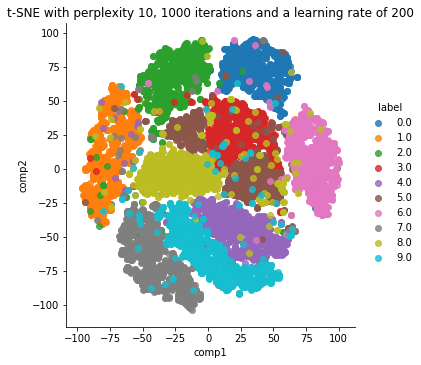

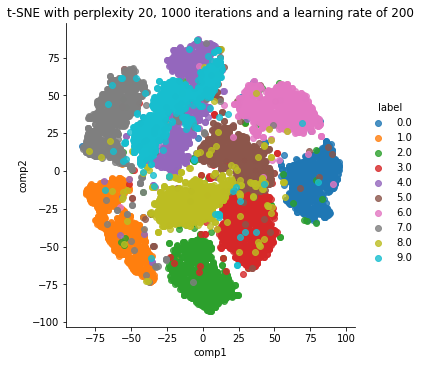

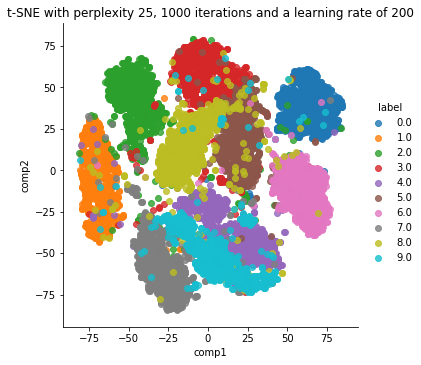

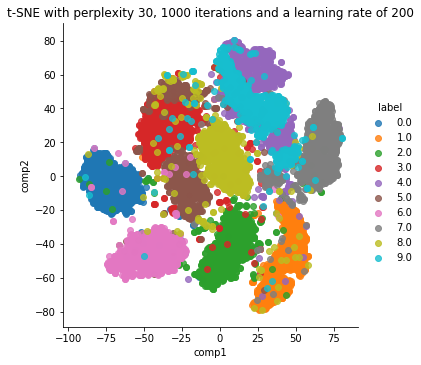

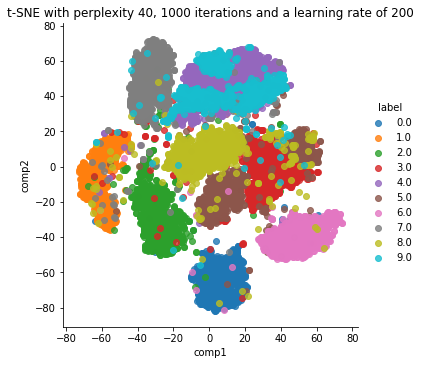

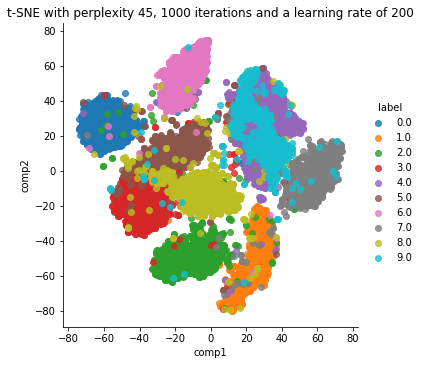

In [194]:
perplexities = [5, 10 , 20, 25, 30, 40 , 45]
for e in perplexities:
    print("perplexity: " + str(e))
    tsne_easy(77,X, y, e, 1000,200)

Learningrate: 10
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.041s...
[t-SNE] Computed neighbors for 10000 samples in 22.677s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.872051
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.389328
[t-SNE] KL divergence after 1000 iterations: 2.217634
Learnin

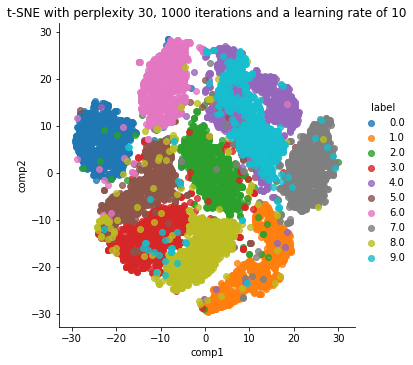

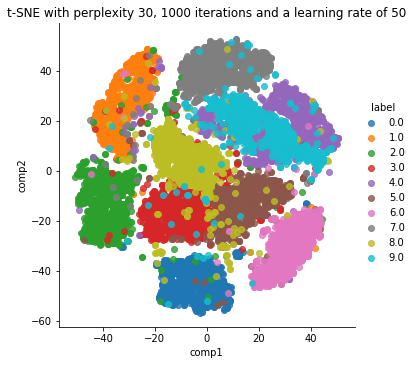

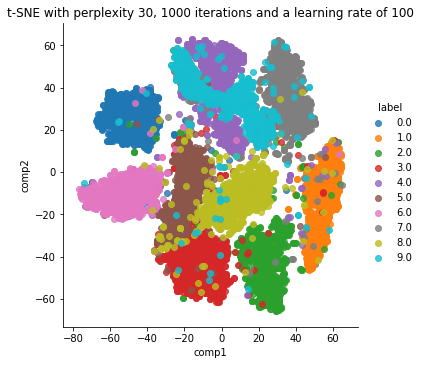

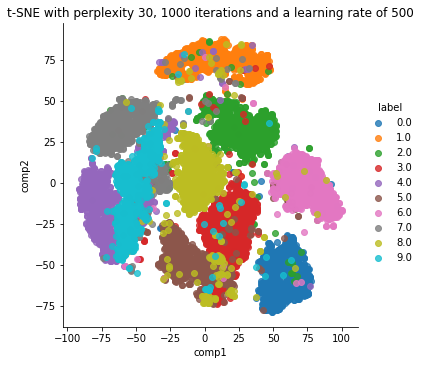

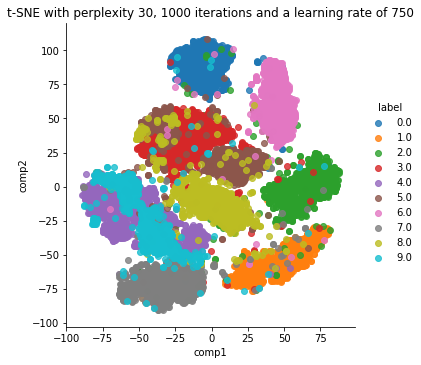

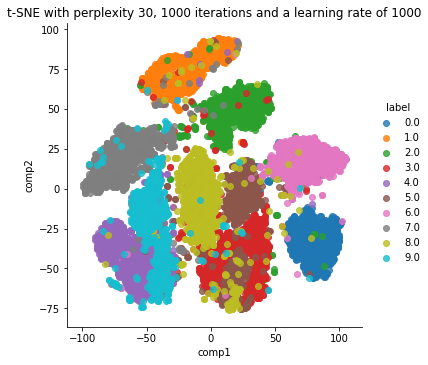

In [196]:
learning = [10, 50, 100, 500, 750, 1000]
for e in learning:
    print("Learningrate: " + str(e))
    tsne_easy(77,X, y, 30, 1000, e)

Iterations: 250
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.037s...
[t-SNE] Computed neighbors for 10000 samples in 24.318s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.848620
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.993790
[t-SNE] KL divergence after 251 iterations: 179769313486231570

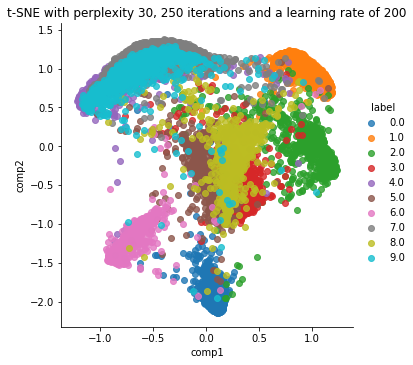

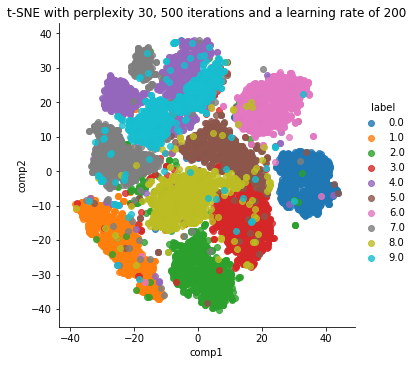

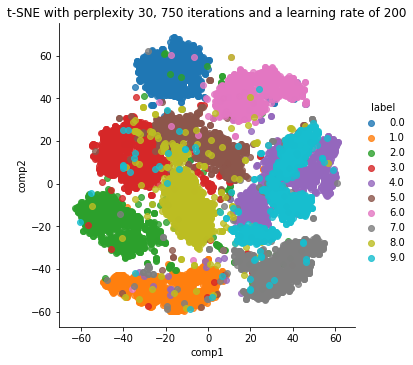

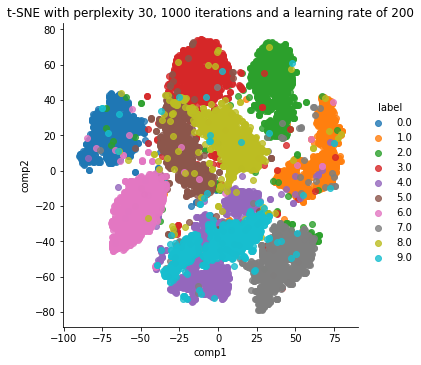

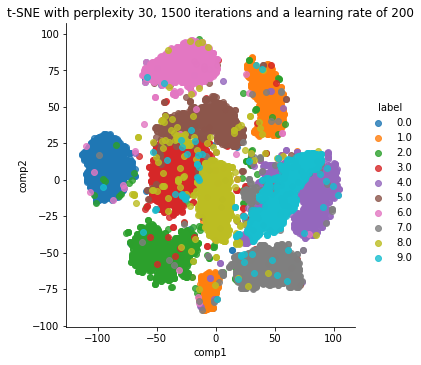

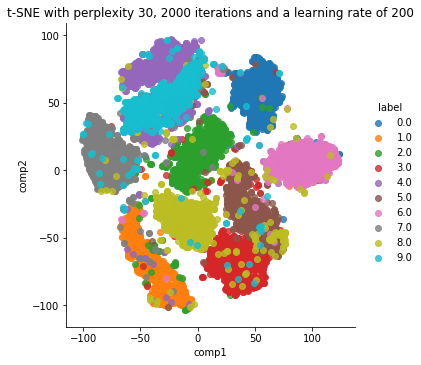

In [198]:
iterations = [250, 500, 750, 1000, 1500, 2000]
for e in iterations:
    print("Iterations: " + str(e))
    tsne_easy(77, X, y, 30, e, 200)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.034s...
[t-SNE] Computed neighbors for 10000 samples in 21.495s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.190560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.765533
[t-SNE] KL divergence after 251 iterations: 1797693134862315708145274237317043

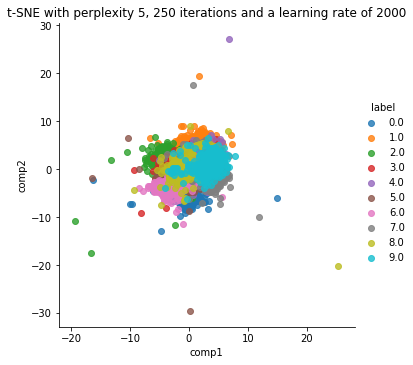

In [200]:
# just for fun
tsne_easy(77, X, y, 5, 250, 2000)

<a id='tsne_3'></a>

As long as I keep the learning rate between 10 and 1000 or so, the t-SNE is quite robust to changes in it. It is robust to changes in iterations as well, as long as there are over 250 iterations. With 250 iterations it started to some weird things and looked quite a bit different from the other graphs. 

<a id='kmean'></a>

## K-means

1. How did you choose k?

    I knew how many there should be

2. How did you evaluate your clustering?

    Silhouette score

3. [Visualize your clusters using t-SNE](#k3)

4. [Did you scale your data?](#k4)
   
   I did in the general sense of dividing by 255. I also tried with sci-kit learn's standard scaler

5. [How robust is your clustering?](#k5)

    Compared to the t-SNE, not really great. 

First I reduced my data to 77 components with PCA since I have way too many right now for k-means to play nice. Then I chose K = 10 since I know there are ten groups. Then I ran a series of k's and used an elbow graph to see what the data said. The elbow graph didn't really give a clear elbow, though there is kind of one around 6 so I'll use that. I used t-SNE to compare my k=10 to my k=6. I also evaluated both choices using a sillhoute score. As can be seen, both of my clustering algorithms did awful (around 0.07 each) so it makes sense that visualizing it, it doesn't do very well. 

In [35]:
pca = PCA(n_components=77)
Kpca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans.fit(Kpca)
sk_clusters = kmeans.predict(Kpca)
labels = kmeans.labels_
silhouette_score(Kpca, labels, metric='euclidean')

0.0752545600783778

In [37]:
def elbow_graph(low,high, df):
    sses = []
    for k in range(low,high):
        kmeans = KMeans(n_clusters=k, n_init=50, n_jobs=-1)
        kmeans.fit(df)
        sses.append(kmeans.inertia_)
    plt.plot(range(low,high), sses)
    plt.title("Elbow Graph for KMeans")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Distances")

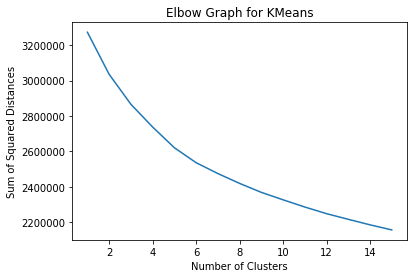

In [38]:
elbow_graph(1,16, Kpca)

<a id='k3'></a>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.047s...
[t-SNE] Computed neighbors for 10000 samples in 27.468s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.883894
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.010399
[t-SNE] KL divergence after 1000 iterations: 1.793095


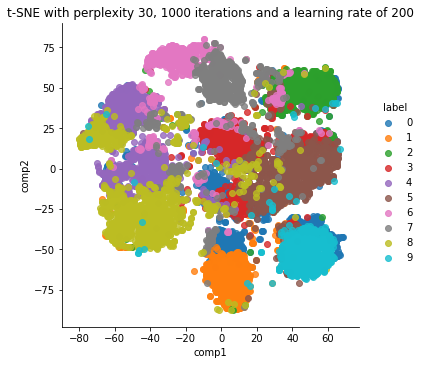

In [46]:
tsne_easy(77, X, sk_clusters, 30, 1000, 200)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.056s...
[t-SNE] Computed neighbors for 10000 samples in 24.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.844786
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.549652
[t-SNE] KL divergence after 1000 iterations: 1.783743


0.07895935812365434

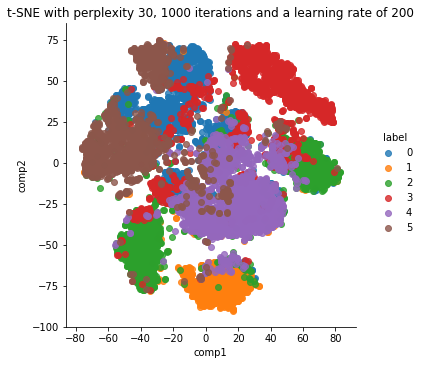

In [36]:
pca = PCA(n_components=77)
Kpca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=6, n_init=50, n_jobs=-1)
kmeans.fit(Kpca)
sk_clusters = kmeans.predict(Kpca)
tsne_easy(77, X, sk_clusters, 30, 1000, 200)
labels = kmeans.labels_
silhouette_score(Kpca, labels, metric='euclidean')

<a id='k4'></a>

PCA technically automatically scales the data. But I also can try this with pre-scaling and see how it does. Usually, you scale data for K-means when the distance does not mean anything. I'll be honest, since each number does represent a change in hues, scaling might not be the best idea here. However, since all the scales are the same, the change in the distances might also be scaled accordingly in a way, so scaling might be okay here. It managed to get an even lower silhouette_score than the other ones, so I don't think scaling was necessary here.

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaled_df = scaler.transform(X)

In [43]:
pca = PCA(n_components=77)
Kpca = pca.fit_transform(scaled_df)
kmeans = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
kmeans.fit(Kpca)
sk_clusters = kmeans.predict(Kpca)
labels = kmeans.labels_
silhouette_score(Kpca, labels, metric='euclidean')

0.055113827141318766

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.050s...
[t-SNE] Computed neighbors for 10000 samples in 29.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.985574
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.009064
[t-SNE] KL divergence after 1000 iterations: 1.708268


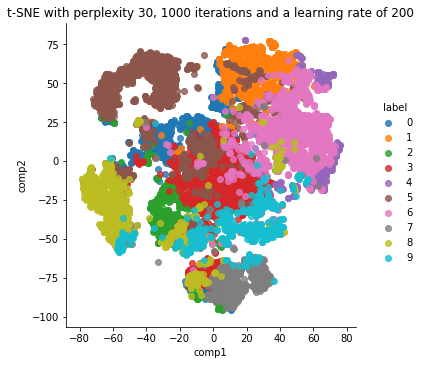

In [44]:
tsne_easy(77, scaled_df, sk_clusters, 30, 1000, 200)

<a id='k5'></a>

This model does not seem to be very robust overall (or very accurate compared to even the t-SNE, with lots of the clusters being split apart). That being said, I'll try this with 3 samples of 10,000 each and see how the silhouette scores compare. Actually, the scores are pretty close (and uniformly terrible) so maybe this is more robust than I thought. I can't get the t-SNE to work for some reason, so I can't visualize the clusters really. Just comparing the scaled and non-scaled ones though, 5,3 and 8 are together in the first but not the second, so the clusters probably aren't robust overall.     

In [49]:
for i in range(3):
    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000

    pca = PCA(n_components=77)
    X_pca = pca.fit_transform(X)
    X_select = X_pca[rows[:n_select]]

    pca = PCA(n_components=77)
    Kpca = pca.fit_transform(X_select)
    kmeans = KMeans(n_clusters=10, n_init=50, n_jobs=-1)
    kmeans.fit(Kpca)
    sk_clusters = kmeans.predict(Kpca)
    labels = kmeans.labels_
    print(i)
    print(silhouette_score(Kpca, labels, metric='euclidean'))

0
0.07124928766515574
1
0.07624297749312206
2
0.07610007689123609


<a id='hc'></a>

## Hierachial Clustering

1. [Plot your dendrogram (do multiple)](#hc1)

2. [How many clusters seem reasonable based off your graph?](#hc1)

3. [How does your dendrogram change with different linkage methods? (use all 5)](#hc3)

First I made a simple function to run each linkage. I also greatly reduced the number of samples I was working with because 70,000 is too much. I also did my PCA of 77 to further reduce the amount of data I was working with. 

In [21]:
def link(v, df):
    Z = linkage(df, v)
    plt.figure(figsize=(20, 20))
    plt.title(v)
    _ = dendrogram(Z)

complete
ward
average
single
centroid


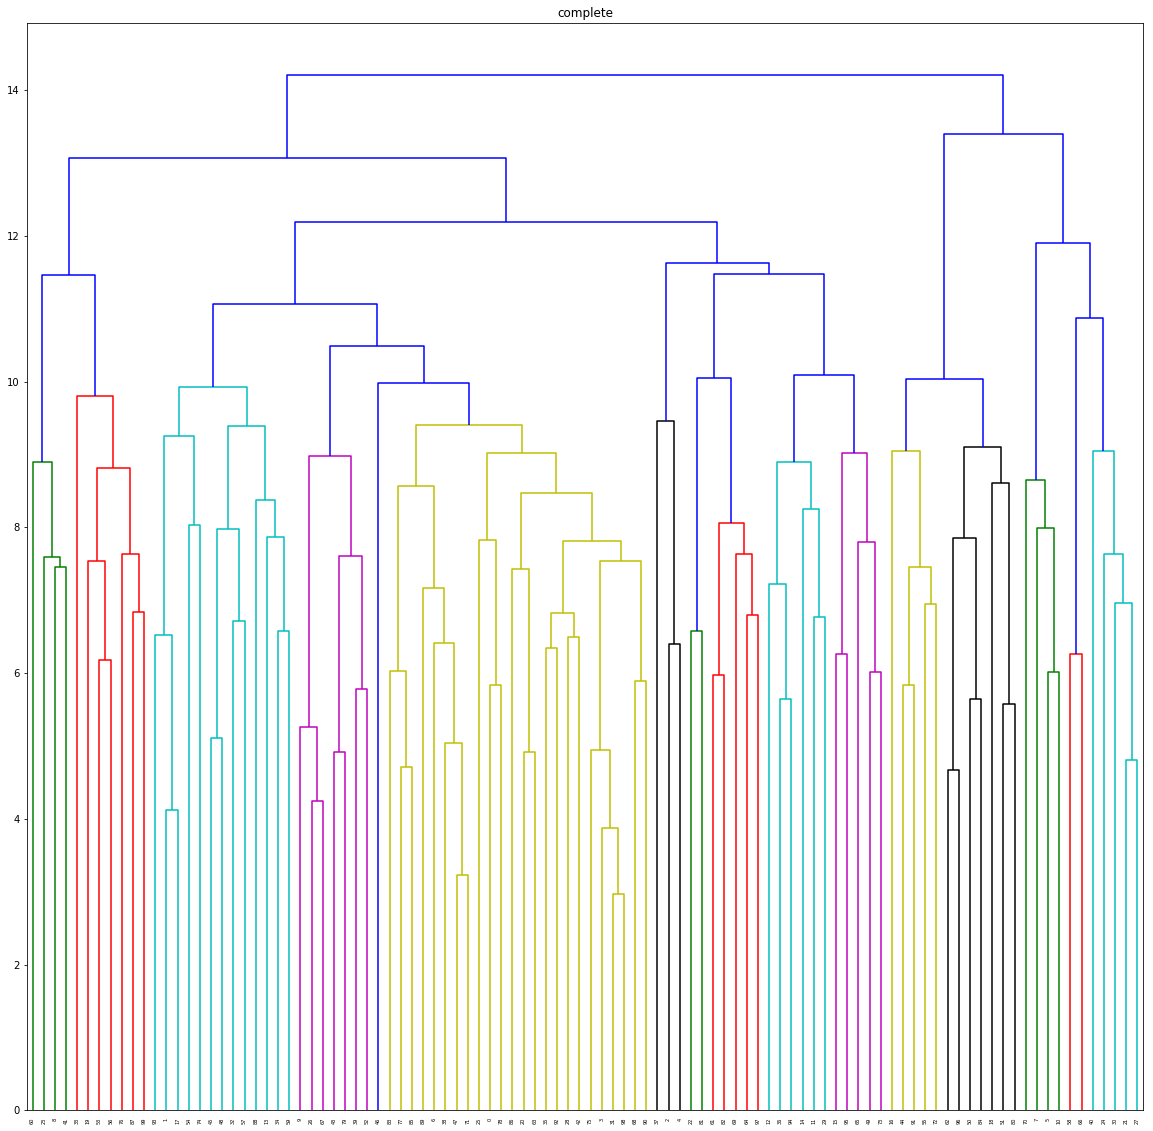

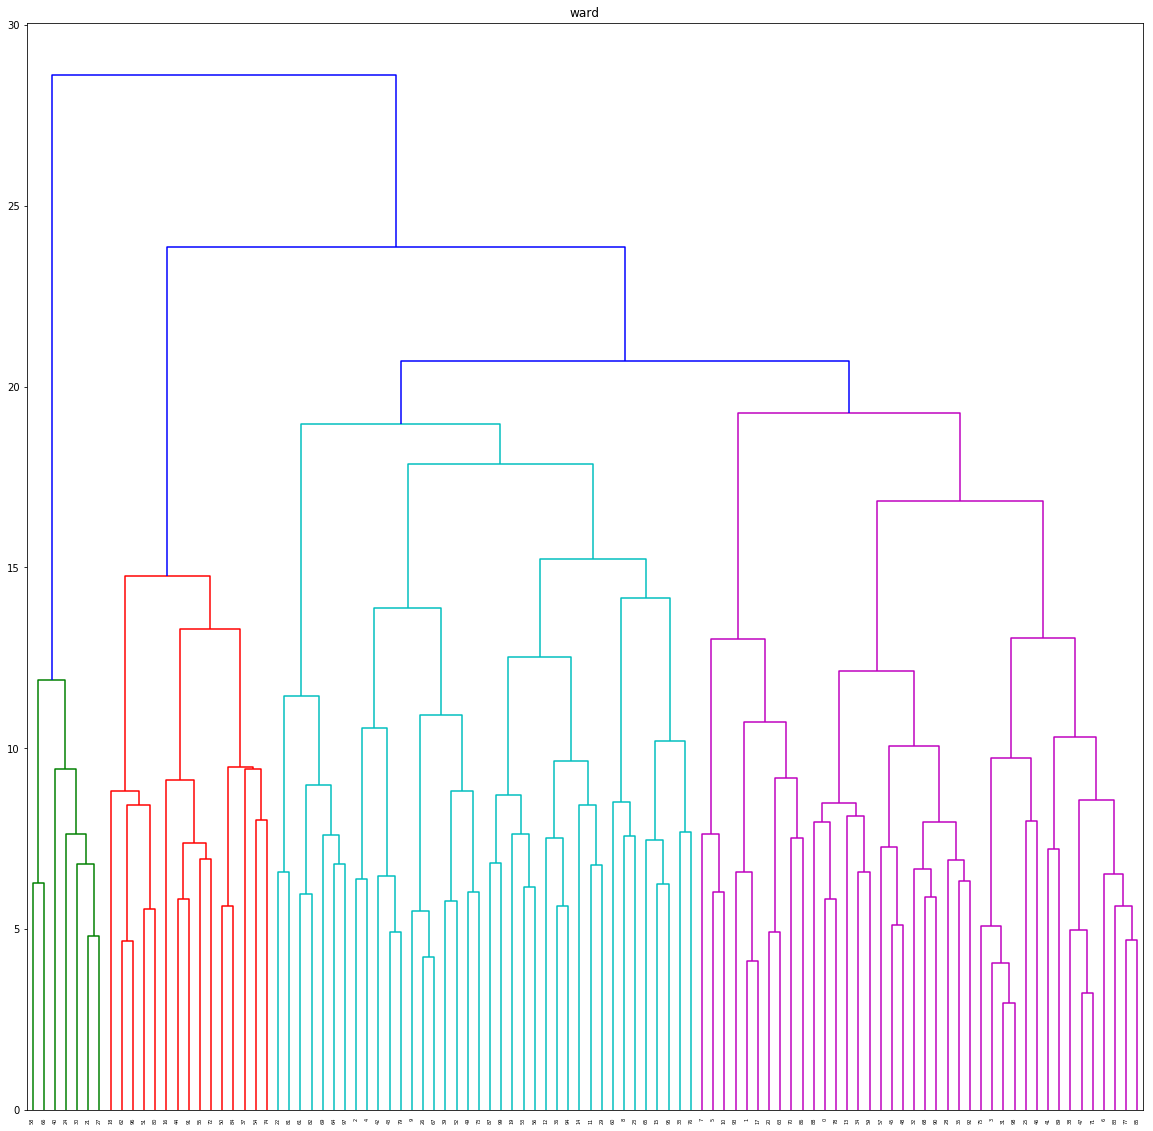

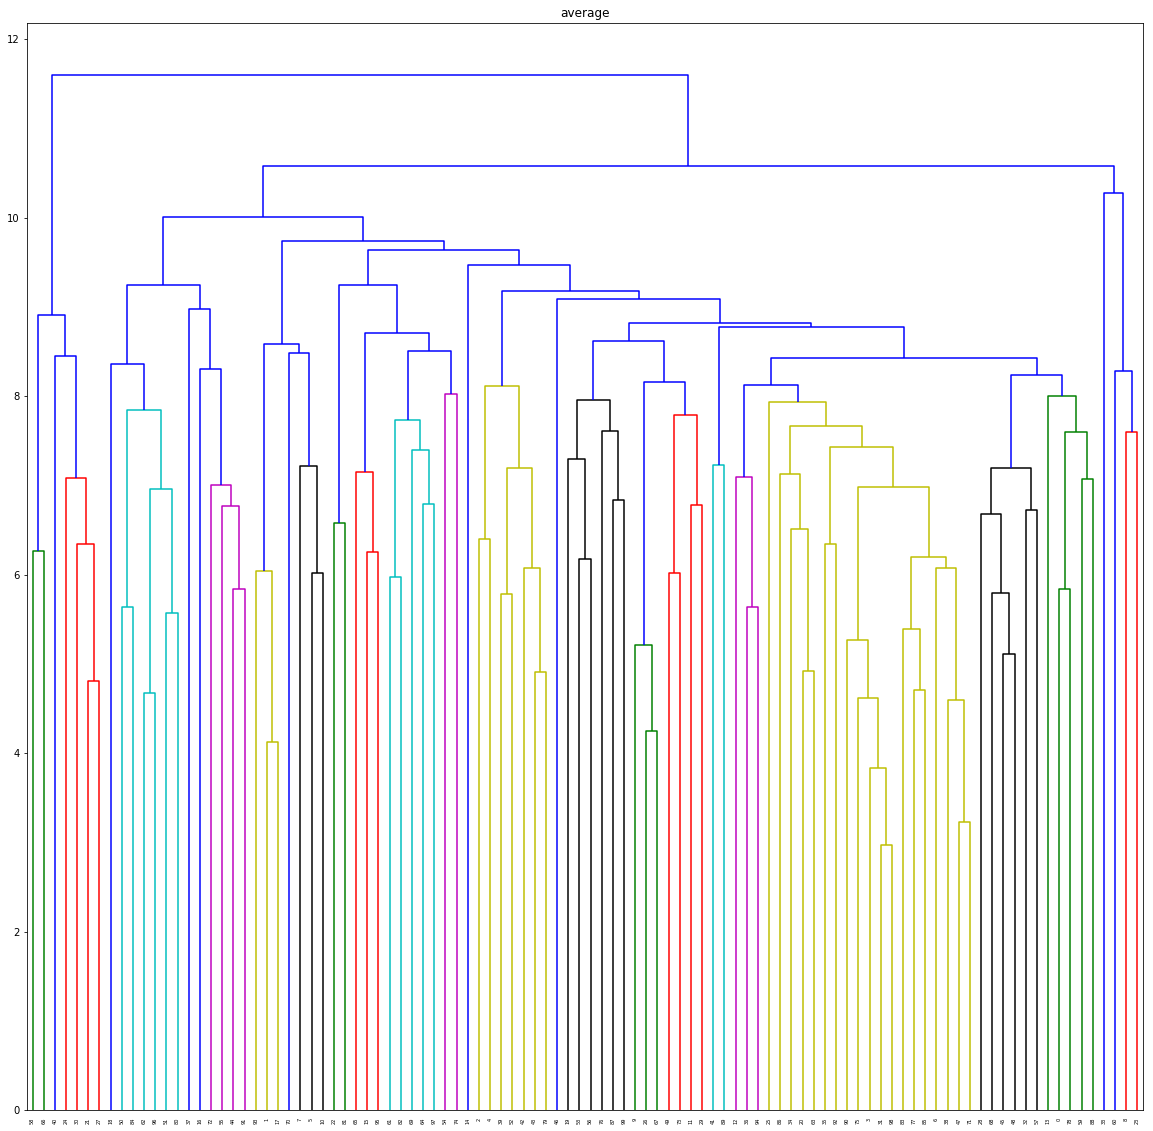

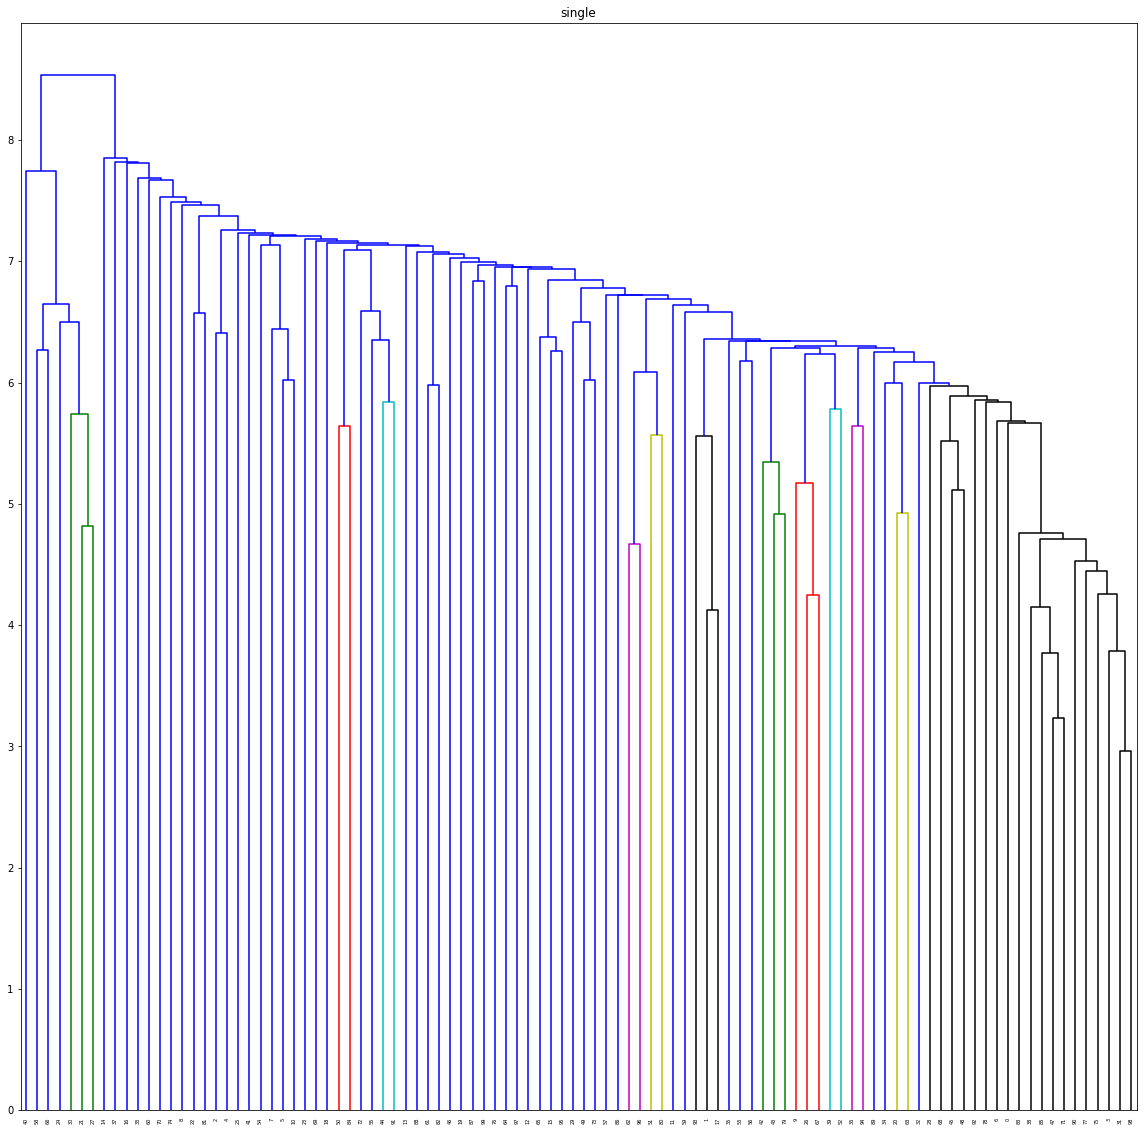

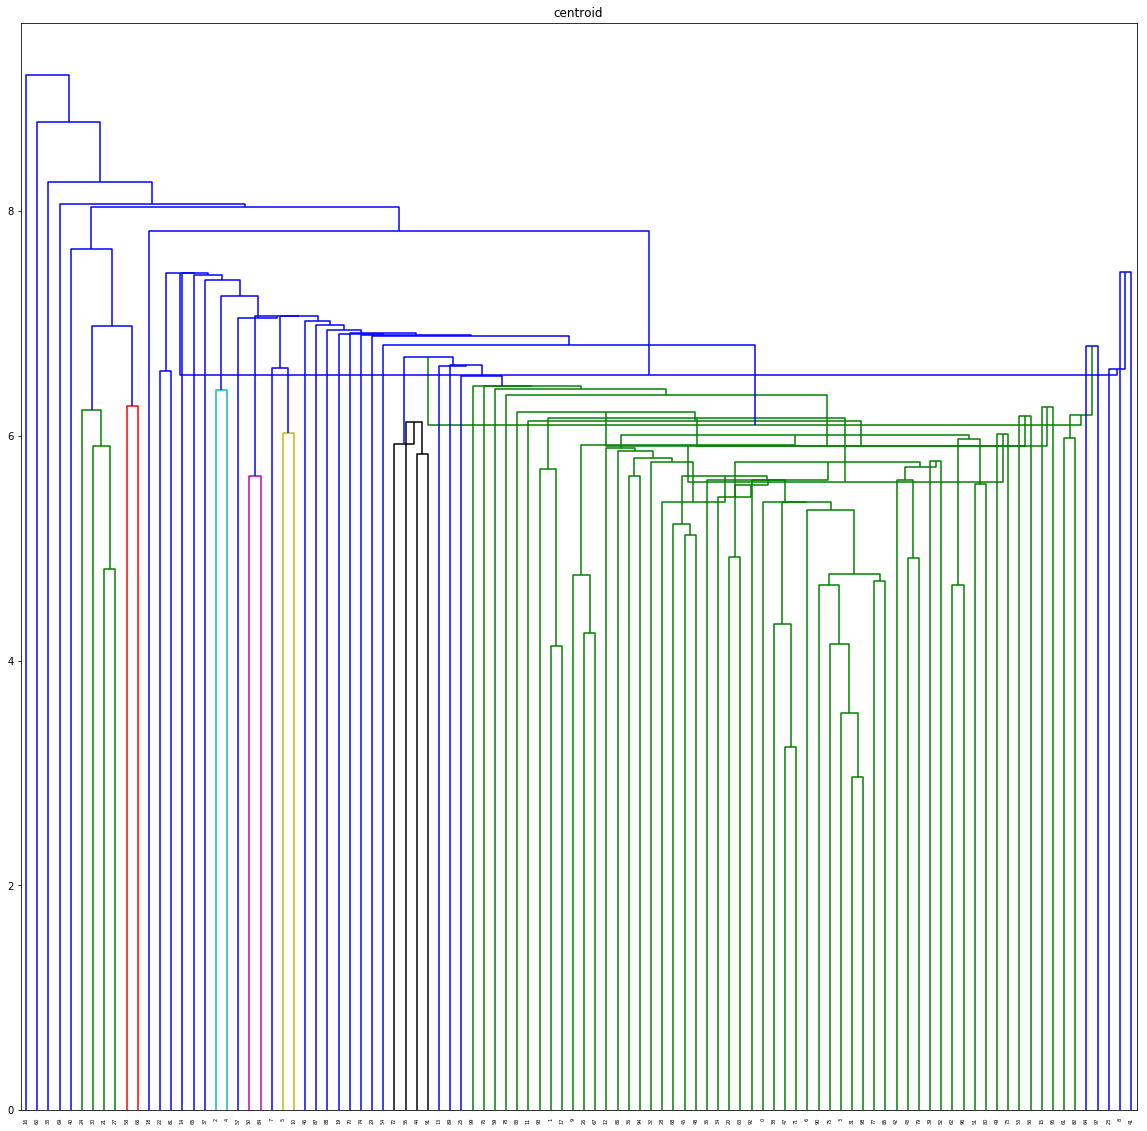

In [22]:
linkages = ['complete', 'ward', 'average', 'single', 'centroid']

rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 100

pca = PCA(n_components=77)
X_pca = pca.fit_transform(X)
X_select = X_pca[rows[:n_select]]

for e in linkages:
    link(e, X_select)

<a id='hc1'></a>


Looking at these different graphs, it seems that ward does the best. I plotted it again alone (and with a different random sample) and it once again showed the reasons I chose it. It shows 4 main clusters (the 4 colors) and by choosing a point just above where the red group splits (since the green group is all in its own branch anyway) which is around 15, I get 8 or 9 clusters. This is quite close to the 10 expected clusters. Looking at the redone graph below, it gives 7 color groups which is also around the 7 or 8 clusters given at 15. So this seems somewhat robust and again what is about expected. This is especially true since it is likely that 8 and 3 or 4 and 9 are being combined into one cluster. I'll graph it one more time to see if it continues to be robust. This is 6 colors and around 10 clusters at 15, so once again around what I saw in the other two and what we should see given that there are 10 numbers.

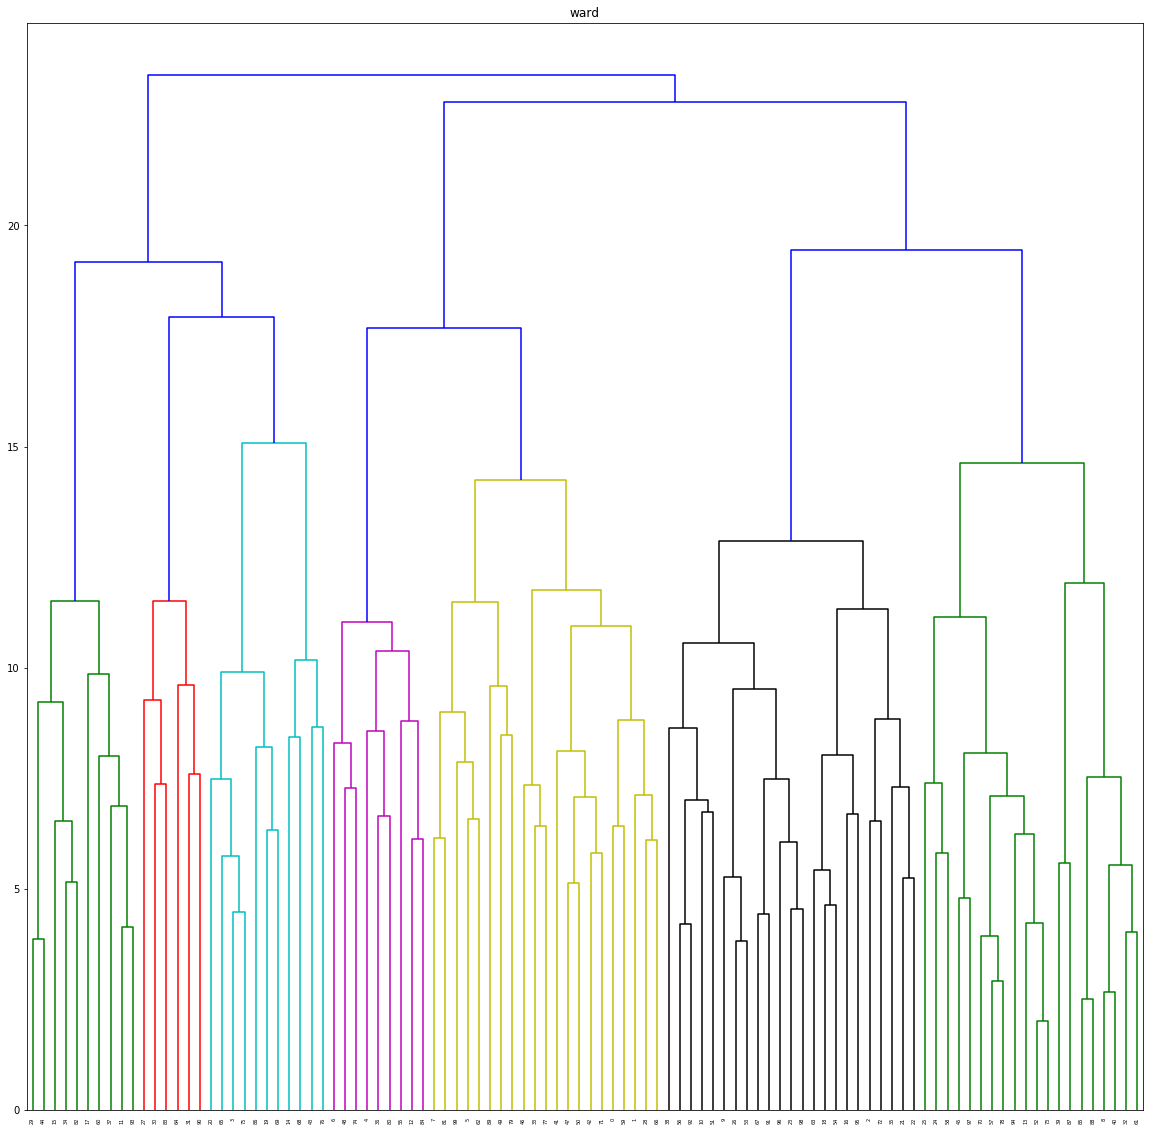

In [31]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 100

pca = PCA(n_components=77)
X_pca = pca.fit_transform(X)
X_select = X_pca[rows[:n_select]]

link('ward', X_select)

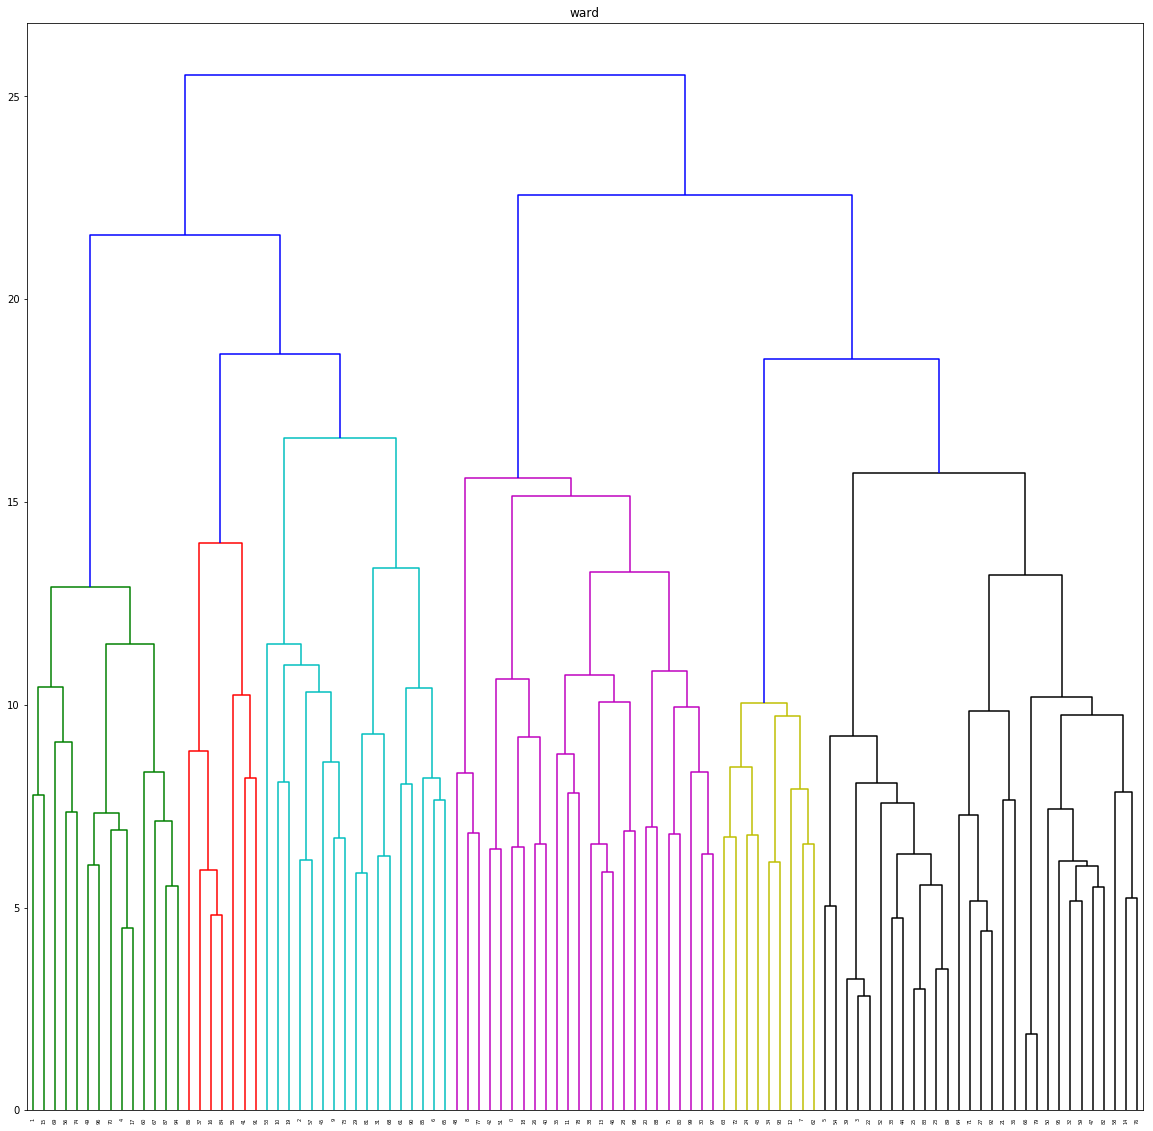

In [33]:
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 100

pca = PCA(n_components=77)
X_pca = pca.fit_transform(X)
X_select = X_pca[rows[:n_select]]

link('ward', X_select)

<a id='hc3'></a>

Each way of linking the nodes provided a different looking graph. The complete, ward and average graphs all provide fairly clean divisions and clusters. However, the complete and average linkages create many more clusters (especially top level ones as shown by the different colors) than the ward linkage. 

Single and Centriod, on the other hand, look quite a bit different. Single, after making one big division, made a whole bunch of little splits in quite succesion. Lots of nodes were just thrown into the junk "blue" cluster which shows that this one did not perform very well. And I do not even know how to read this one. It allows lines to cross and like the single linkage, it creates a lot of splits really fast, making the number of clusters hard to measure.

Pretty much all the methods except complete made two clusters quite quickly, with one of the clusters being much larger than the other. Complete provided more balance in the sizes of these two initial cluters. Overall, my choice in choosing the ward linkage was probably quite appropriate.